In [165]:
# Import libraries
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [166]:
# Read the csv file into a Dataframe object
df = pd.read_csv('laptops.csv')

In [167]:
# Show the firts rows
df.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [168]:
# Refactor column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['laptop', 'status', 'brand', 'model', 'cpu', 'ram', 'storage',
       'storage_type', 'gpu', 'screen', 'touch', 'final_price'],
      dtype='object')

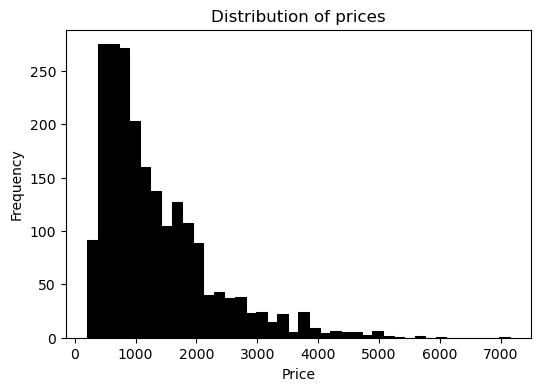

In [169]:
# Plot the data distribution
plt.figure(figsize=(6, 4))

sns.histplot(df.final_price, bins=40, color='black', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

In [170]:
# Select a subset of columns for ML training
base = ['ram','storage','screen','final_price']
df = df[base]
df.head()

,ram,storage,screen,final_price
0,8,512,15.6,1009.00
1,8,256,15.6,299.00
2,8,256,15.6,789.00
3,16,1000,15.6,1199.00
4,16,512,15.6,669.01


In [171]:
# Look for columns with missing values (column 'screen' has missing values)
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

In [172]:
# The median (50% percentile) for variable 'ram'
df.ram.median()

16.0

In [173]:
# Split the dataset in train, validation and test with 60%/20%/20% distribution
n = len(df)
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - (n_train + n_val)

idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

## Linear Regression

In [174]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [175]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

## Simple feature engineering

In [176]:
def prepare_X_zero(df):
    df = df.copy()
    df = df.fillna(0)
    
    X = df.values
    return X

In [177]:
# Training a linear regression model without regularization filling missing values with 0.
X_train = prepare_X_zero(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_zero(df_val)
y_pred = w_0 + X_val.dot(w)
score = rmse(y_val, y_pred)

print('score', round(score, 2))

score 597.36


In [178]:
def prepare_X_mean(df):
    df = df.copy()
    mean_value = df['screen'].mean() 
    df['screen'] = df['screen'].fillna(value=mean_value)

    X = df.values
    return X

In [179]:
# Training a linear regression model without regularization filling missing values in column 'screen' with the mean value.
X_train = prepare_X_mean(df_train)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X_mean(df_val)
y_pred = w_0 + X_val.dot(w)
score = rmse(y_val, y_pred)

print('score', round(score, 2))

score 600.26


## Regularization

In [180]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [181]:
X_train = prepare_X_zero(df_train)
X_val = prepare_X_zero(df_val)

In [182]:
# Looking for the best model
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    print('score for %s =' % r, round(score, 2))
   

score for 0 = 597.36
score for 0.01 = 597.36
score for 0.1 = 597.35
score for 1 = 597.21
score for 5 = 597.01
score for 10 = 597.06
score for 100 = 597.9


In [183]:
# Evaluating different seed values
scores = []

n = len(df)
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - (n_train + n_val)

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    np.random.seed(s)

    idx = np.arange(n)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
    df_test = df_shuffled.iloc[n_train+n_val:].copy()
    
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    
    X_train = prepare_X_zero(df_train)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X_zero(df_val)
    y_pred = w_0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    scores.append(score)
    print('score for seed %s = ' % s, round(score, 2))

print('\nscores =', scores)

std = np.std(scores)
print('\nstd scores', round(std, 3))

score for seed 0 =  565.45
score for seed 1 =  636.8
score for seed 2 =  588.96
score for seed 3 =  597.81
score for seed 4 =  571.96
score for seed 5 =  573.24
score for seed 6 =  647.34
score for seed 7 =  550.44
score for seed 8 =  587.33
score for seed 9 =  576.1

scores = [565.4520868770995, 636.7985423056726, 588.955869790796, 597.8148920012515, 571.962791511103, 573.238325661895, 647.3438328407194, 550.4398184485962, 587.3335036169963, 576.101792943313]

std scores 29.176


In [185]:
# Combine train and validation datasets. Use seed 9.
np.random.seed(9)

n = len(df)
n_train = int(0.6 * n)
n_val = int(0.2 * n)
n_test = n - (n_train + n_val)

idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [186]:
df_train_val = pd.concat([df_train, df_val], axis=0)
y_train_val = np.concatenate([y_train, y_val])

X_train_val = prepare_X_zero(df_train_val)
X_test = prepare_X_zero(df_test)

w_0, w = train_linear_regression_reg(X_train_val, y_train_val, r=0.001)
y_pred = w_0 + X_test.dot(w)
score = rmse(y_test, y_pred)

print('score for seed 9 = ', round(score, 2))

score for seed 9 =  608.61
